# EDA - General Artist and Song

In [117]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from sqlalchemy import create_engine

%matplotlib inline

##### Loading In Tables for EDA

In [2]:
artists = pd.read_csv('../data/artist_list_v2.csv').set_index('s_artist_id')
songs = pd.read_csv('../data/song_list_v2.csv').set_index('s_song_id')
genres = pd.read_csv('../data/genres.csv')
gs = pd.read_csv('../data/gsong_lookup.csv').set_index('gs_id')
sec_means = pd.read_csv('../data/spotify_section_means.csv')
sec_var = pd.read_csv('../data/spotify_section_var.csv')
song_feats = pd.read_csv('../data/song_feats.csv').set_index('id')
timbre_means = pd.read_csv('../data/timbre_means.csv')
timbre_var = pd.read_csv('../data/timbre_var.csv')
pitch_means = pd.read_csv('../data/pitch_means.csv')
pitch_var = pd.read_csv('../data/pitch_var.csv')

In [3]:
timbre_means.rename({'Unnamed: 0':'song_id'}, axis= 1, inplace=True)
timbre_var.rename({'Unnamed: 0':'song_id'}, axis= 1, inplace=True)
pitch_means.rename({'Unnamed: 0':'song_id'}, axis= 1, inplace=True)
pitch_var.rename({'Unnamed: 0':'song_id'}, axis= 1, inplace=True)

In [4]:
timbre_means.set_index('song_id', inplace=True)
timbre_var.set_index('song_id', inplace=True)
pitch_means.set_index('song_id', inplace=True)
pitch_var.set_index('song_id', inplace=True)

In [105]:
genres = pd.read_csv('../data/genres.csv')
genres.rename({'Unnamed: 0':'genre_id'}, axis= 1, inplace=True)
genres.set_index('genre_id', inplace=True)

### Merging `songs` & `song_feats` DataFrames

In [38]:
main_wfeats = pd.merge(songs, song_feats, left_on=songs.index, right_on=song_feats.index)

## Looking Through Decades

In [6]:
songs.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [7]:
len(songs['album_release_date'].iloc[5])

4

##### Converting `album_release_date` to DateTime

I'll keep to year only values, considering that it's all I accurately have currently

In [8]:
songs['album_release_date'] = songs['album_release_date'].apply(lambda x: x + '-01-01' if len(x) == 4 else x)
songs['album_release_date'] = songs['album_release_date'].apply(lambda x: re.sub(r'(-\d*)','',x))
songs['album_release_date'] = songs['album_release_date'].apply(lambda x: int(x))

In [9]:
songs.columns

Index(['album_release_date', 'artist_id', 'artist_name', 'duration_ms',
       'explicit', 'linked_album', 'song_title'],
      dtype='object')

##### All Songs by Year

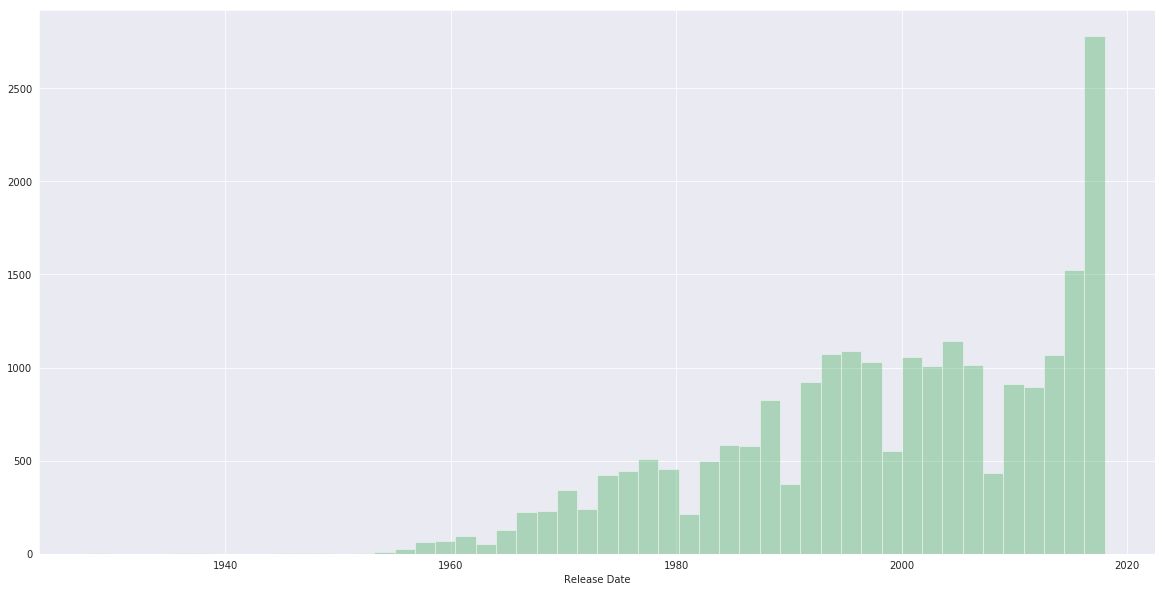

In [10]:
plt.figure(figsize=(20,10))
sns.set_style(style='darkgrid')
sns.distplot(songs['album_release_date'], kde=False, color='#4eb264', )
plt.xlabel('Release Date');

In [11]:
songs['album_release_date'].value_counts().head()

2018    1573
2017    1207
2015     780
2016     744
2005     621
Name: album_release_date, dtype: int64

It seems as though the vast majority of songs within this dataset have been released after 1990. This *could* be an issue to do with Spotify's information on release dates, however, it could also just be indicative of what people are listening to in 2018. Even though these artists received awards through different decades, they could've released new music which would be more popular currently. 

That being said, it would be interesting to see the distribution of when music in the RIAA Gold and Platinum database was actually released, to get a scope of the share of artists per decade.

#### Songs by Genre & Year

In [12]:
gs.columns

Index(['song_id', 'genre_id', 'genre_name', 'artist_id'], dtype='object')

In [97]:
gs['genre_name'].value_counts().head(25)

rock                    3970
mellow gold             2578
album rock              2352
dance pop               2322
soft rock               2308
urban contemporary      2305
rap                     2262
hip hop                 2173
pop rock                2155
pop                     2124
pop rap                 2055
classic rock            1899
r&b                     1875
quiet storm             1832
country                 1817
folk rock               1737
post-grunge             1707
hard rock               1640
new wave pop            1497
southern hip hop        1387
gangster rap            1382
funk                    1377
hip pop                 1334
new jack swing          1330
contemporary country    1329
Name: genre_name, dtype: int64

I'll pick rock, urban contemporary, country, and dance pop, 2 of, 3 of, all, none

##### Divvying Songs into `Most Distinct` Genres for Plotting

In [136]:
genres_dict = {'rock':[], 'urban contemporary':[], 'country':[], 'dance pop':[]}
for song_id, genre in gs[['song_id', 'genre_name']].values:
    if genre in genres_dict.keys():
        genres_dict[genre].append(song_id)

In [135]:
gs[['song_id', 'genre_name']].values

array([['6SluaPiV04KOaRTOIScoff', 'dance pop'],
       ['6SluaPiV04KOaRTOIScoff', 'electropop'],
       ['6SluaPiV04KOaRTOIScoff', 'europop'],
       ..., 
       ['09WwqFDqX2zv8rlvf4xYAk', 'nu metal'],
       ['09WwqFDqX2zv8rlvf4xYAk', 'post-grunge'],
       ['09WwqFDqX2zv8rlvf4xYAk', 'rock']], dtype=object)

In [147]:
val = 3
ex_dict = {'blue':[3, 4], 'green':[2,12], 'purple':[7,18]}
for k, v in ex_dict.items():
    print(len(v))

2
2
2


In [156]:
def mdg(x, gd):
    '''
    Find most distinct genre
    '''
    mdct = mdg_dict(x)
    merge_wdf = {}
    for val in x:
        for k, v in gd.items():
            if val in v:
                mdct[val].append(k)
    for song, genres in mdct.items():
        if len(genres) == 0:
            merge_wdf[song] = 'none'
        if len(genres) == 1:
            merge_wdf[song] = genres[0]
        if len(genres) == 2:
            merge_wdf[song] = 'two'
        if len(genres) == 3:
            merge_wdf[song] = 'three'
    return merge_wdf

In [123]:
main_wfeats['key_0'].values

array(['6SluaPiV04KOaRTOIScoff', '5qEVq3ZEGr0Got441lueWS',
       '5kqIPrATaCc2LqxVWzQGbk', ..., '2ayphdNEBBaAErWdTMAhsm',
       '7BY005dacJkbO6EPiOh2wb', '09WwqFDqX2zv8rlvf4xYAk'], dtype=object)

In [157]:
merge_wdf = mdg(main_wfeats['key_0'].values, genres_dict)

In [161]:
merge_wdf = pd.Series(merge_wdf)

In [163]:
main_wfeats = main_wfeats.merge(pd.DataFrame(merge_wdf), left_on='key_0', right_on=merge_wdf.index)

In [166]:
main_wfeats.rename({0:'mdg', 'key_0':'song_id'}, axis=1, inplace=True)

##### Top 10 Genres

In [13]:
top10_genres = gs['genre_name'].value_counts().head(10)

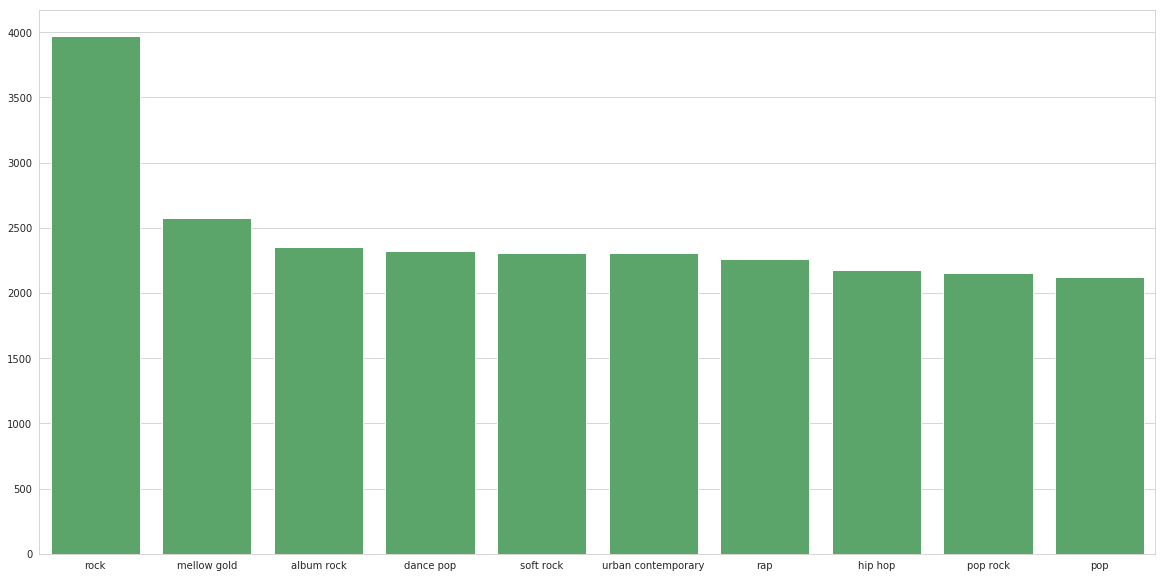

In [14]:
plt.figure(figsize=(20,10))
sns.set_style('whitegrid')
sns.barplot(top10_genres.index, top10_genres.values, color='#4eb264');
# plt.

##### Bottom 10 Genres

In [15]:
bottom10_genres = gs['genre_name'].value_counts().tail(10)

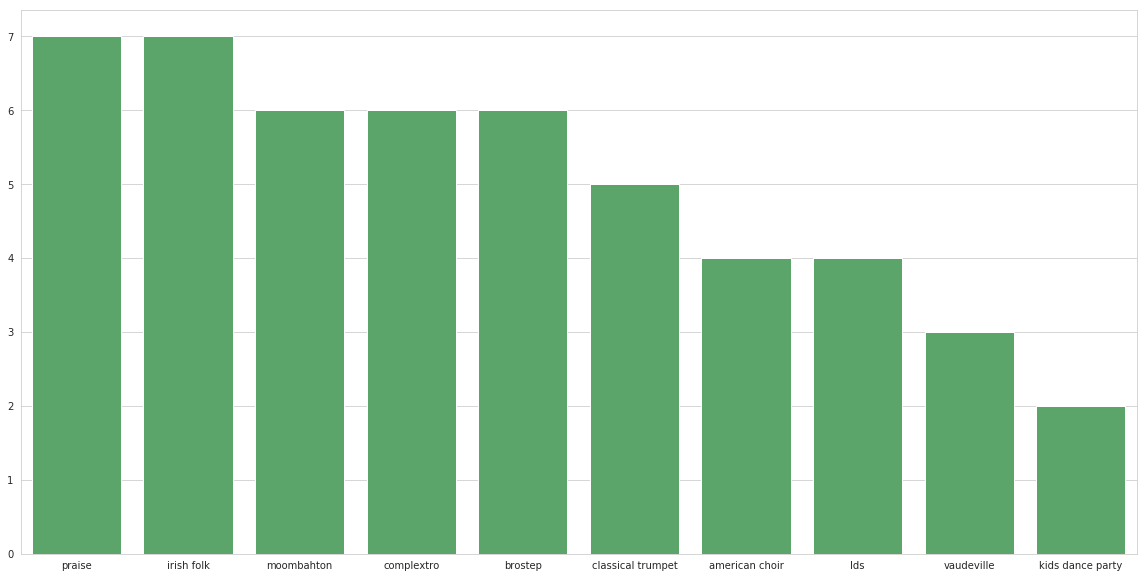

In [16]:
plt.figure(figsize=(20,10))
sns.set_style('whitegrid')
sns.barplot(bottom10_genres.index, bottom10_genres.values, color='#4eb264');

I have no idea what a bunch of these mean. Might be good to grab descriptions.

#### Most Popular Genres & the Makeup of Release Dates

##### Creating List of 10 most popular genres

In [17]:
top10_lookup = gs[['genre_name', 'song_id']][gs['genre_name'].isin(top10_genres.index)]

In [18]:
top10_wdate = top10_lookup.merge(pd.DataFrame(songs['album_release_date']), left_on='song_id', right_on=songs.index)

In [19]:
top10_wdate.columns

Index(['genre_name', 'song_id', 'album_release_date'], dtype='object')

In [21]:
# sns.barplot(x=top10_wdate['genre_name'])

## Looking at Audio Features

#### Features Against Genres

In [31]:
songs.index

Index(['6SluaPiV04KOaRTOIScoff', '5qEVq3ZEGr0Got441lueWS',
       '5kqIPrATaCc2LqxVWzQGbk', '3aVyHFxRkf8lSjhWdJ68AW',
       '0zIyxS6QxZogHOpGkI6IZH', '7xYDqpnQdqlgxBDm2ySggl',
       '3slY9zt6oUOPDaUwRfgqzH', '12D0n7hKpPcjuUpcbAKjjr',
       '5e0O7MjhNHq9G67qDFM8nR', '3EcmNKUi5OOWXUGOsxlCca',
       ...
       '1EuqRlDP9RuzeCRVcjr1PY', '0ttHPvvVg9PwCWLtDr6ckf',
       '0nk5VSbrqNdO8Bj7swMN1a', '0VAoDsKh7Or84V8xP7p1Fs',
       '2yxkvnyno37480Hv1wuAee', '1oDhq2VrC2db3CWR3aDGeP',
       '2PN3gbuBn5WBEwrEJH3xiu', '2ayphdNEBBaAErWdTMAhsm',
       '7BY005dacJkbO6EPiOh2wb', '09WwqFDqX2zv8rlvf4xYAk'],
      dtype='object', name='s_song_id', length=22914)

In [22]:
song_feats.head()

danceability  energy  key  loudness  mode  \
id                                                                  
62bOmKYxYg7dhrC6gH9vFn         0.610   0.926    8    -4.843     0   
46n2EGFnPC3tzWCN1Aqe26         0.550   0.587    2    -6.279     1   
2AW37v0bDyuOzGP3XnmFuA         0.636   0.873    0    -4.672     0   
594M0rqYMOo8BhMGEdoi5C         0.686   0.915    7    -4.447     1   
0Jc8qF1mUPo1A96HE9QxZz         0.706   0.861   11    -6.684     1   

                        speechiness  acousticness  instrumentalness  liveness  \
id                                                                              
62bOmKYxYg7dhrC6gH9vFn       0.0479        0.0310          0.001200    0.0821   
46n2EGFnPC3tzWCN1Aqe26       0.0329        0.3540          0.000000    0.1280   
2AW37v0bDyuOzGP3XnmFuA       0.0710        0.0407          0.000001    0.0372   
594M0rqYMOo8BhMGEdoi5C       0.0364        0.0028          0.000007    0.2330   
0Jc8qF1mUPo1A96HE9QxZz       0.1540        0.0341          0.000000    0.1270   

                        valence    tempo  duration_ms  time_signature  \
id                                                                      
62bOmKYxYg7dhrC6gH9vFn    0.861  172.638       200400               4   
46n2EGFnPC3tzWCN1Aqe26    0.466  165.975       284760               4   
2AW37v0bDyuOzGP3XnmFuA    0.908  165.071       192427               4   
594M0rqYMOo8BhMGEdoi5C    0.796  110.054       211000               4   
0Jc8qF1mUPo1A96HE9QxZz    0.923  119.946       238427               4   

                        key_changes  
id                                   
62bOmKYxYg7dhrC6gH9vFn            5  
46n2EGFnPC3tzWCN1Aqe26            5  
2AW37v0bDyuOzGP3XnmFuA            6  
594M0rqYMOo8BhMGEdoi5C            5  
0Jc8qF1mUPo1A96HE9QxZz            4

##### Danceability

In [95]:
song_feats.sort_values('danceability', ascending=True).index

Index(['3FepYSKnGMMlR9URg0PSuR', '7CAjcNPoCiTIKCN8XejSGy',
       '5lu4pwb800iNz4cA5iaaoZ', '5V4JJSa7femKY5jCTeUrFo',
       '7Bk3p8UqcP4sItaWNWbvXL', '6bLZPMmjb3PlX6XPUdJpW9',
       '23ryVoyGTrfO3F0GblIfnz', '78NOjcwjSb7qSrPtKUAHiy',
       '4kliYpYKJhH7IJooqqlRfv', '7L19WZ9a7YFZhuEaOzr9yw',
       ...
       '4TJ56OkWrnf2fv2a6T69DL', '3oXn6hDgLacf7ZU031ocqw',
       '4BXfgirIN3i2hgbdITJoer', '3MQmQowCMVhepBDEsuBXIm',
       '3XVozq1aeqsJwpXrEZrDJ9', '0ElLdRiKL4ctv4ZL3r9IRf',
       '11d9oUiwHuYt216EFA2tiz', '6tKRyHen4zoLtt9RcprBGm',
       '5IbMUI4rcWtXlq83UWqTcQ', '5YIF6HSOtHN9HdcE5IPzMe'],
      dtype='object', name='id', length=22902)

##### Energy vs Danceability

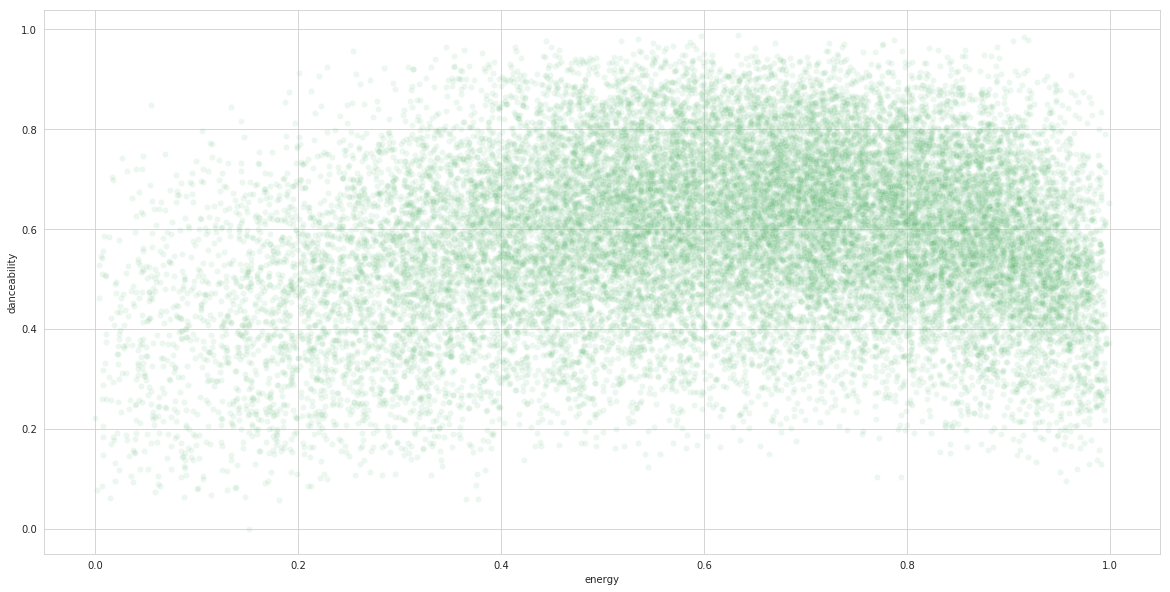

In [41]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['energy'], main_wfeats['danceability'], color='#4eb264', alpha=0.1)

##### Energy vs Danceability (with Key Changes hue)

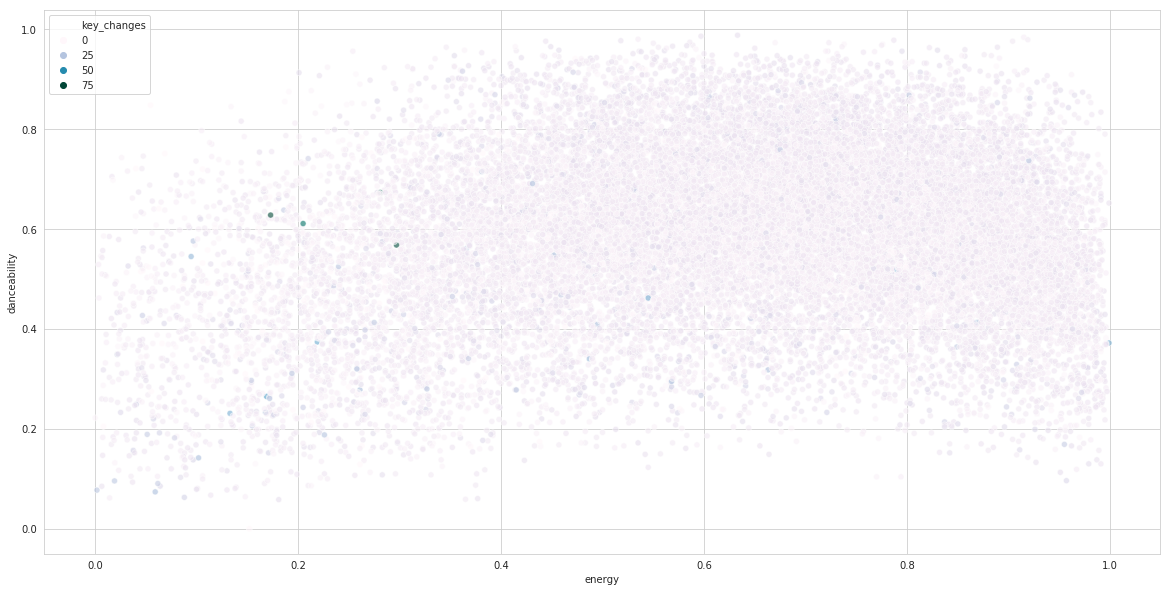

In [188]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['energy'], main_wfeats['danceability'], hue=main_wfeats['key_changes'], palette='PuBuGn', alpha=0.6)

##### Energy vs Valence (with Acousticness hue)

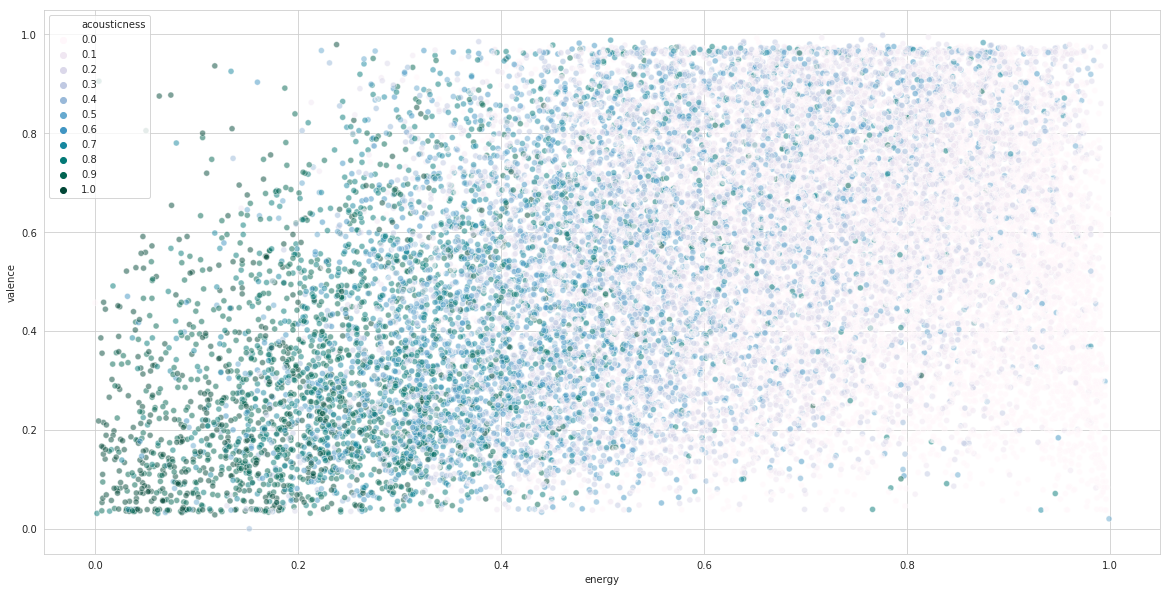

In [96]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['energy'], main_wfeats['valence'], 
                hue=main_wfeats['acousticness'].apply(lambda x: round(x, 1)), alpha=0.5, 
                palette="PuBuGn", legend='full')

##### Energy vs Valence (with Mode hue)

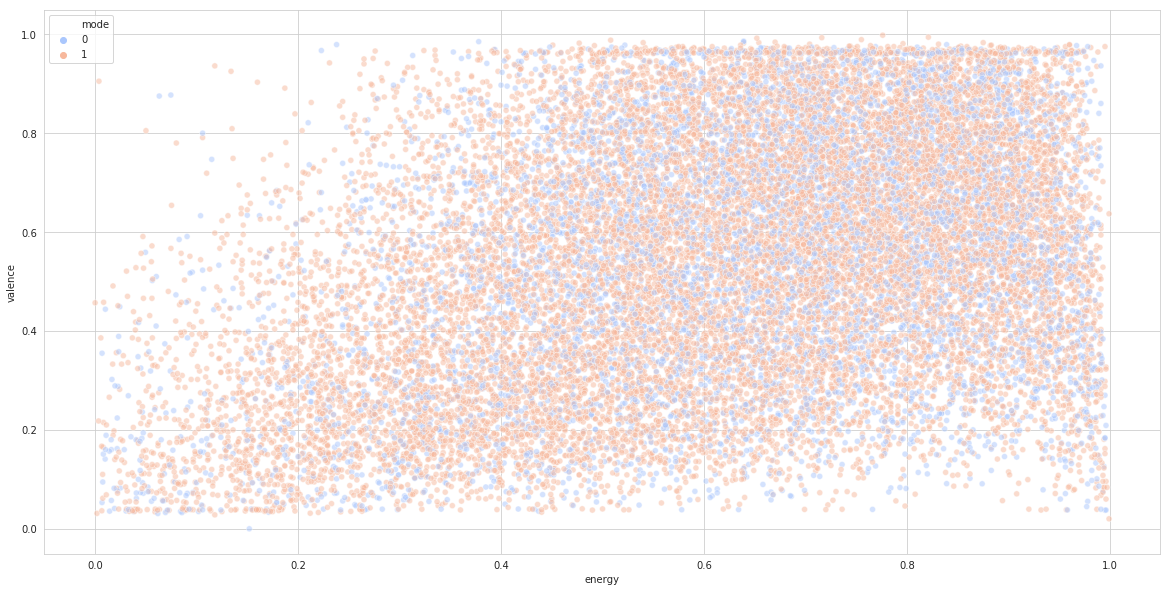

In [183]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['energy'], main_wfeats['valence'], 
                hue=main_wfeats['mode'], alpha=0.5, 
                palette="coolwarm", legend='full')

##### Acousticness vs Energy (Release Year hue)

In [59]:
main_wfeats['album_release_date'].apply(lambda x: round(x, -1)).unique()

array([2000, 2020, 2010, 1990, 1980, 1960, 1970, 1950, 1940, 1930])

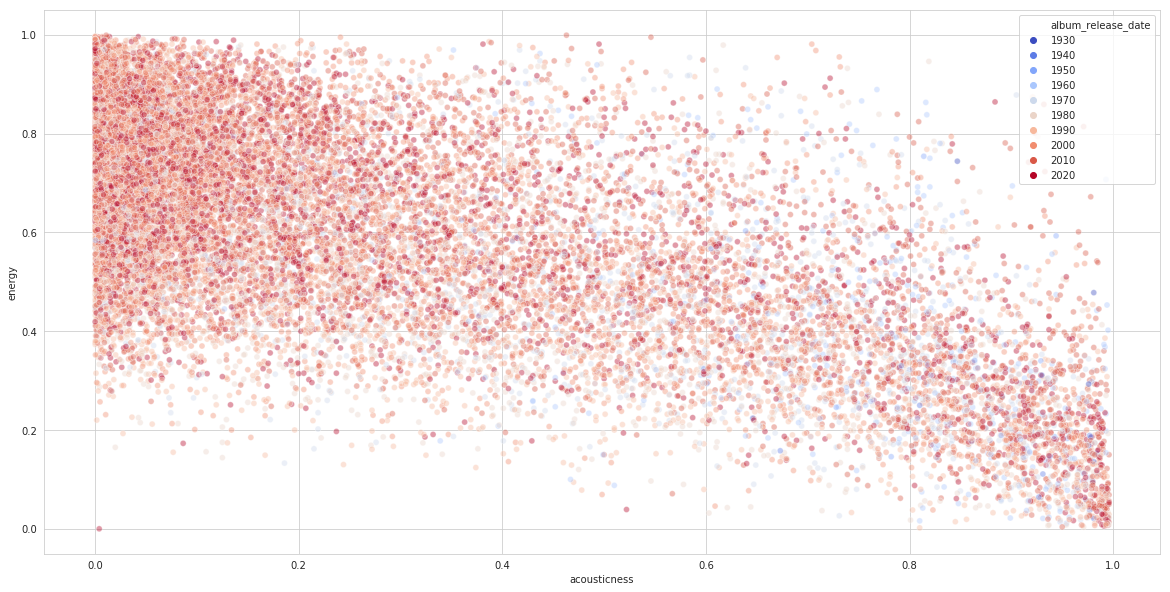

In [65]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['acousticness'], main_wfeats['energy'], 
                hue=main_wfeats['album_release_date'].apply(lambda x: round(x, -1)), palette='coolwarm', alpha=0.4, legend='full')

##### Acousticness vs Danceability (Speechiness Hue)

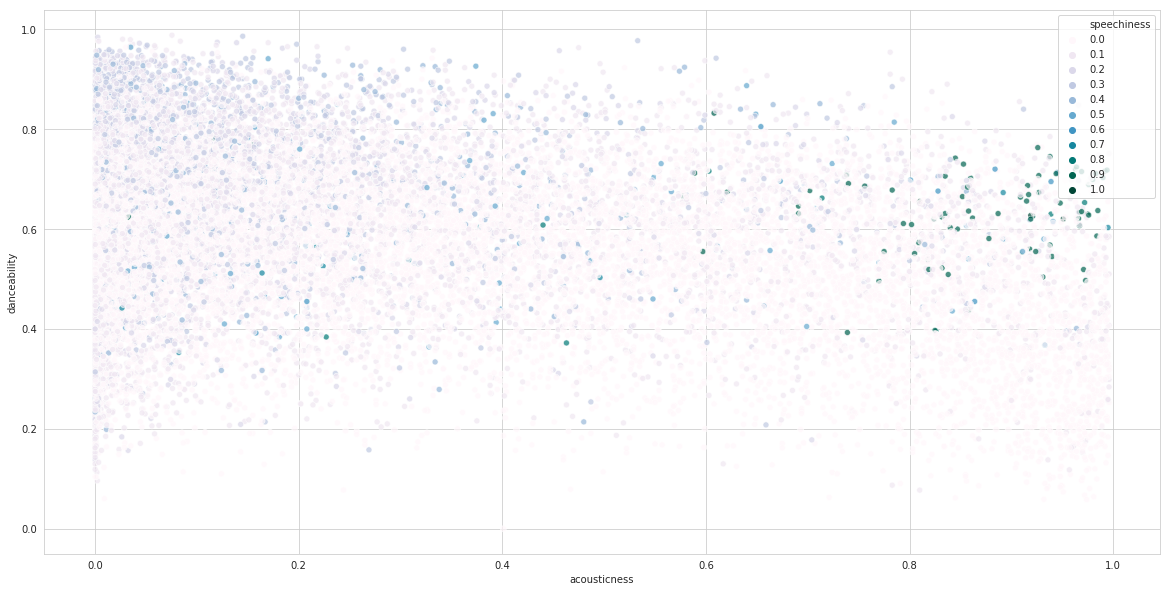

In [194]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['acousticness'], main_wfeats['danceability'], 
                hue=main_wfeats['speechiness'].apply(lambda x: round(x, 1)), alpha=.7, palette='PuBuGn', legend='full')

##### Key vs. Valence

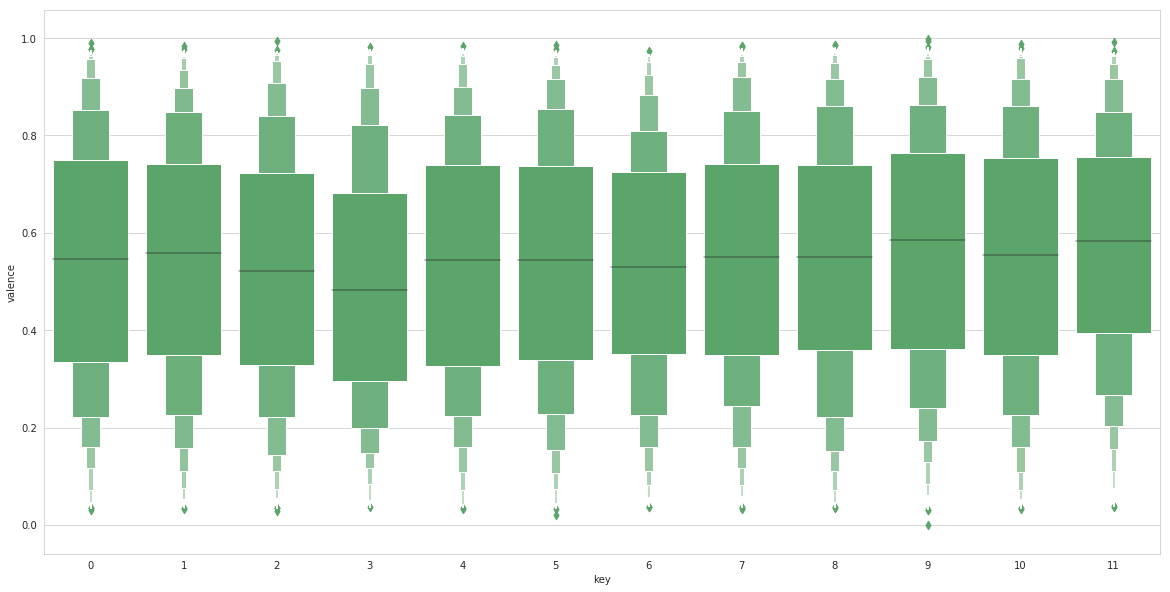

In [70]:
plt.figure(figsize=(20,10))
sns.boxenplot(x=main_wfeats['key'], y=main_wfeats['valence'], color='#4eb264')

##### Key vs. Key Changes (under 20)

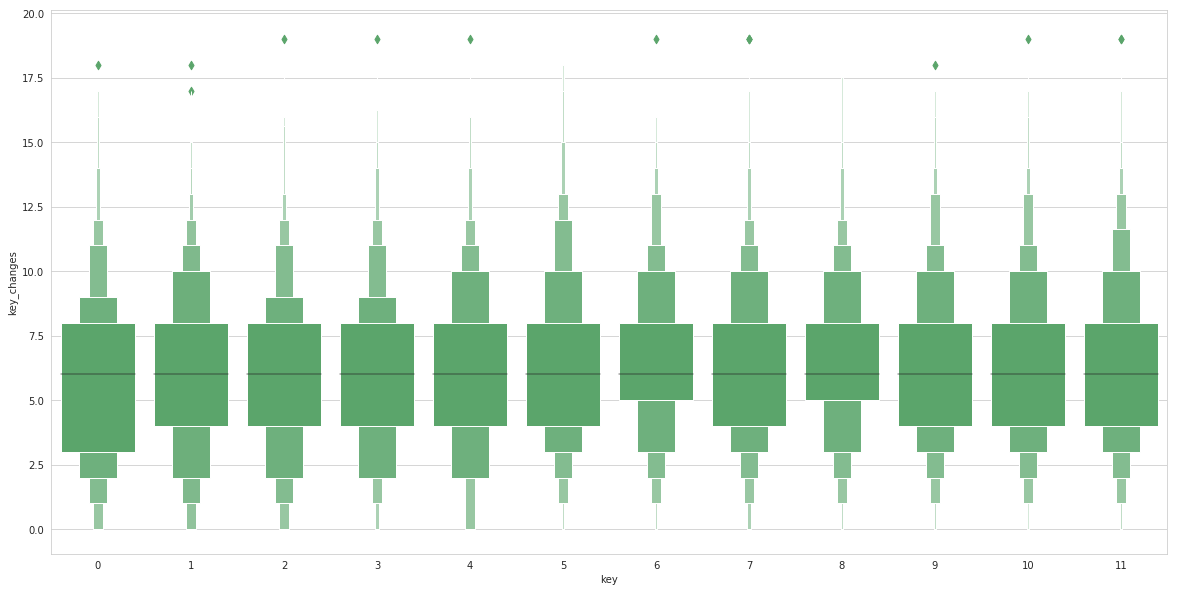

In [77]:
plt.figure(figsize=(20,10))
sns.boxenplot(x=main_wfeats['key'][main_wfeats['key_changes'] < 20], y=main_wfeats['key_changes'][main_wfeats['key_changes'] < 20], color='#4eb264')

##### Key Changes vs Energy

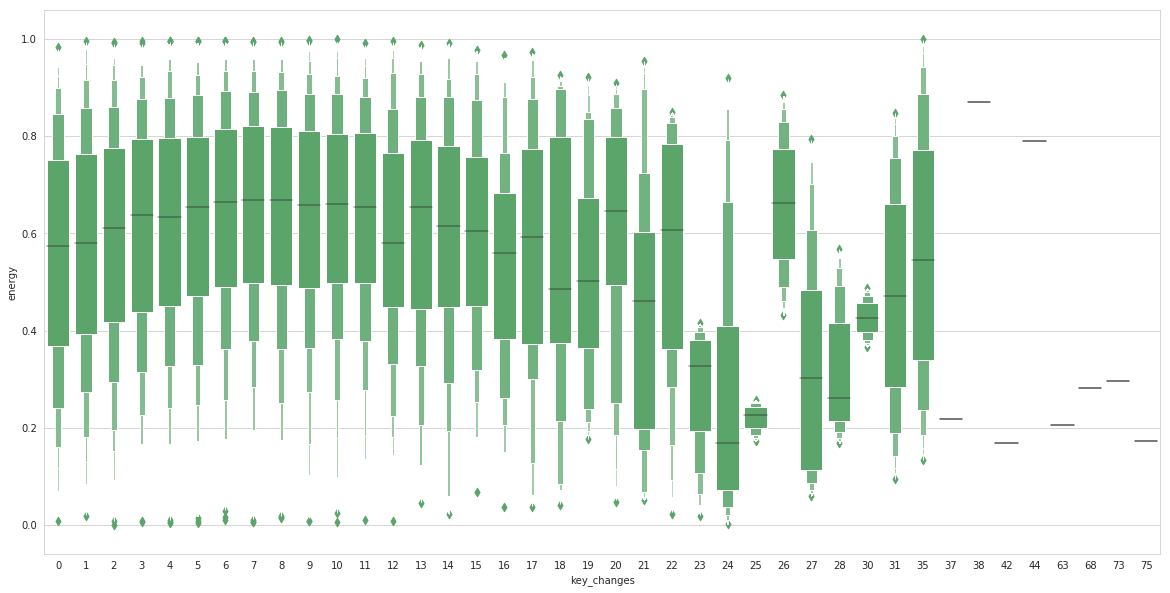

In [78]:
plt.figure(figsize=(20,10))
sns.boxenplot(x=main_wfeats['key_changes'], y=main_wfeats['energy'], color='#4eb264')

#####  Danceability vs Acousticness (Most Distinct Genre hue)

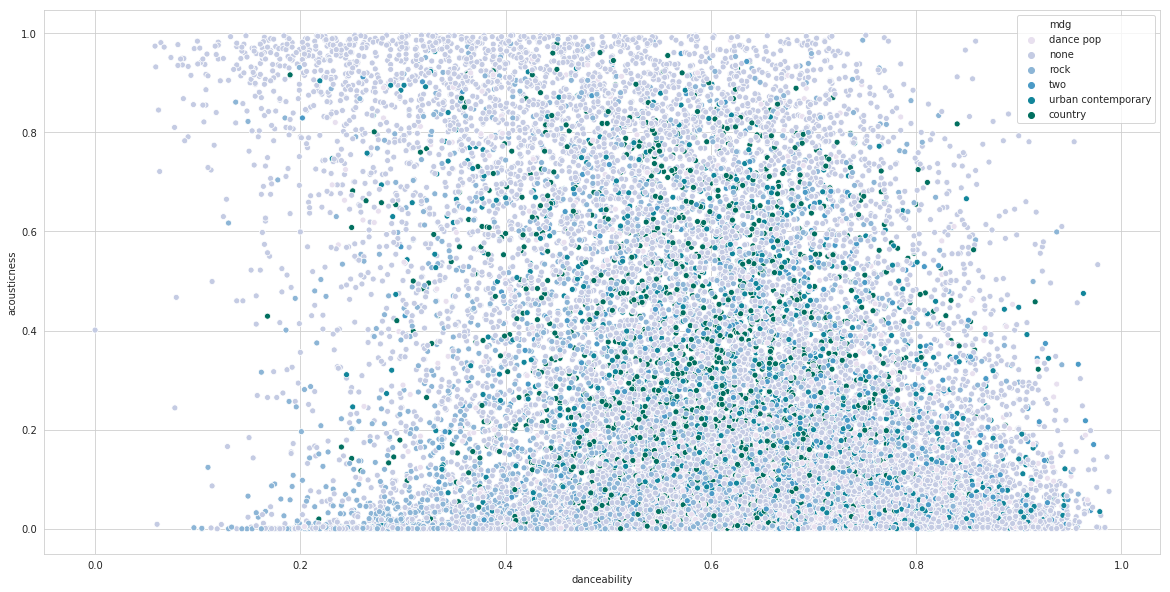

In [171]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['danceability'], main_wfeats['acousticness'], 
                hue=main_wfeats['mdg'], alpha=1, palette='PuBuGn', legend='full');

##### Mode vs Valence (with mdg hue)

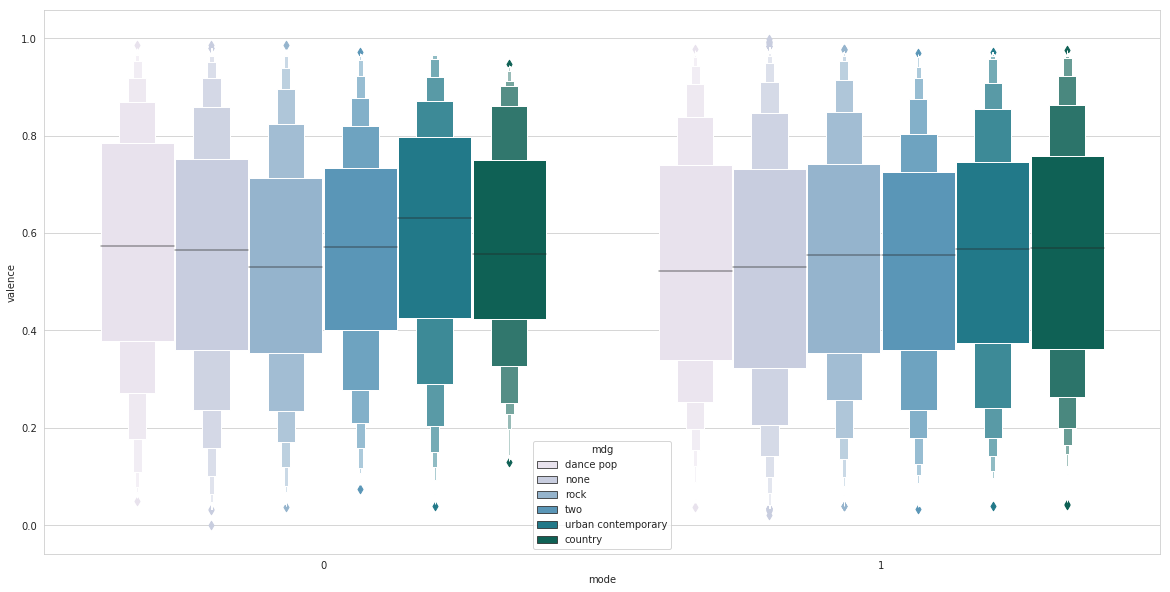

In [192]:
plt.figure(figsize=(20,10))
sns.boxenplot(main_wfeats['mode'], main_wfeats['valence'], hue=main_wfeats['mdg'], palette='PuBuGn');